Predicted digits: [5, 4, 3, 0, 0, 6, 2, 6, 4, 6]


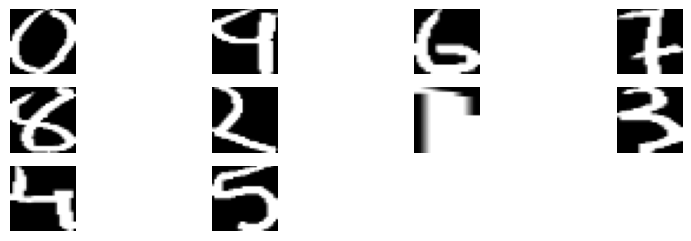

In [ ]:
import torch
import torch.nn as nn
import cv2
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1), #(i-f+2p)/s +1  (32-3+2)/1    +1 = 32
        nn.MaxPool2d(kernel_size=3,stride=2),#(M-P)/s + 1   (32-2)/2  + 1 = 16
        nn.ReLU(),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3),
        nn.MaxPool2d(kernel_size=3,stride=2),  #(M-P)/s + 1   (16-2)/2   +1  =8
        nn.ReLU(),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1), #(i-f+2p)/s +1  (32-3+2)/1    +1 = 32
        #nn.MaxPool2d(kernel_size=3,stride=2),#(M-P)/s + 1   (32-2)/2  + 1 = 16
        nn.ReLU(),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1), #(i-f+2p)/s +1  (32-3+2)/1    +1 = 32
        #nn.MaxPool2d(kernel_size=3,stride=2),#(M-P)/s + 1   (32-2)/2  + 1 = 16
        nn.ReLU(),
        nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,padding=1), #(i-f+2p)/s +1  (32-3+2)/1    +1 = 32
        nn.MaxPool2d(kernel_size=3,stride=2)#(M-P)/s + 1   (32-2)/2  + 1 = 16
    )
    self.fc = nn.Sequential(
        nn.Dropout(),
        nn.Linear(in_features=128,out_features=1024),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(in_features=1024,out_features=1024),
        nn.ReLU(),
        nn.Linear(1024,10)
    )

  def forward(self,x):
    x = self.conv(x)
    x = x.flatten(start_dim=1)
    x = self.fc(x)
    return x

model=CNN()

criterion=nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)
# Load the trained model
state = torch.load('Digit_Recognition (1).pth',map_location=torch.device('cpu'))
model.load_state_dict(state['model'])
optimizer.load_state_dict(state['optimizer'])

# Define a function to preprocess the image and extract digits
def extract_digits(image_path):
    image = Image.open(image_path).convert('L')  # Convert image to grayscale
    _, binary_image = cv2.threshold(np.array(image), 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)  # Binarize image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    digits = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        digit = binary_image[y:y+h, x:x+w]  # Extract digit region
        digit = cv2.resize(digit, (28, 28))  # Resize to MNIST image size (28x28)
        digits.append(digit)
    return digits

# Define a function to predict digits using the model
def predict_digits(digits):
    predictions = []
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    for digit in digits:
        digit = Image.fromarray(digit)
        digit = transform(digit).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            output = model(digit)
            _, predicted = torch.max(output, 1)
            predictions.append(predicted.item())
    return predictions

# Path to the custom photo
photo_path = '/content/download (4).jpg'

# Extract digits from the photo
digits = extract_digits(photo_path)
fig=plt.figure(figsize=(10,10))
rows,cols=len(digits),4
for i in range(1,rows+1):
  img=digits[i-1]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap="gray")
  #plt.title(class_names[label])
  plt.axis(False);
predictions = predict_digits(digits)

# Print the predicted digits
print("Predicted digits:", predictions[::-1])


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.9/777.9 kB 11.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
from ultralytics import YOLO
import cv2

model=YOLO('yolov8n.pt')
results = model("/content/download.jpg",show=True)
cv2.waitKey(0)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/download.jpg: 640x640 1 apple, 318.8ms
Speed: 7.2ms preprocess, 318.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


-1

In [ ]:
!pip install cvzone

  Preparing metadata (setup.py) ... done
  Created wheel for cvzone: filename=cvzone-1.6.1-py3-none-any.whl size=26297 sha256=0d9451934ec0d6d30ba60aba24eef7555e1d9ec55e5ad0c0c47b720471d4f6f4
  Stored in directory: /root/.cache/pip/wheels/2c/9f/b3/92e945ac4a71bf727a92463f38155cc5a4fa49c5010b38ec4c
Successfully built cvzone


In [ ]:
import cvzone
from google.colab.patches import cv2_imshow

cap=cv2.VideoCapture(1)
cap.set(3,1280)
cap.set(4,720)

while True:
  success,img = cap.read()
  cv2_imshow(img)
  cv2.waitKey(1)

AttributeError: 'NoneType' object has no attribute 'clip'